In [55]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import numpy as np
import TransportMaps as TM
import TransportMaps.Maps as MAPS
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
from TransportMaps import KL
mpl.rcParams['font.size'] = 15

# Sequential inference via low-dimensional couplings

We use here the stochastic volatility model to present the decomposability of transports when the target density $\nu_\pi$ is a Markov field. The following model is described in [[OR7]](aa-references.html#Hull1987) and [[OR8]](aa-references.html#Kim1998). The transport map treatment of the problem is described in the paper [[TM4]](aa-references.html#spantini2017) whose results are reported [[here]](cs/stochastic-volatility/cs-stochastic-volatility.html).

We model the log-volatility ${\bf Z}_{\Lambda}$ of the return of a financial asset at times $\Lambda=\{0,1,\ldots,n\}$ with the autoregressive process

$$ {\bf Z}_{k+1} = \mu + \phi ({\bf Z}_k - \mu) + \varepsilon_k \;, \qquad \varepsilon_k \sim \mathcal{N}(0,1) \;, \quad \varepsilon_k {\perp\!\!\!\perp} {\bf Z}_k $$
$$ \qquad \left.{\bf Z}_0 \right\vert \mu,\phi \sim \mathcal{N}\left(\mu, \frac{1}{1-\phi^2}\right) \;, \qquad \mu \sim \mathcal{N}(0,1) \;\, $$
$$ \qquad \phi = 2 \frac{\exp(\phi^\star)}{1+\exp(\phi^\star)} - 1 \;, \qquad \phi^\star \sim \mathcal{N}(3,1) \;. $$

For $k \in \Xi \subset \Lambda$, estimate parameters $\Theta = (\mu,\phi)$ and states $\left\{ {\bf Z}_k \right\}$, given observations

$$ {\bf Y}_k = \xi_k \exp\left(\frac{1}{2}{\bf Z}_k\right) \;, \qquad \xi_k \sim \mathcal{N}(0,1) \;, \quad \xi_k {\perp\!\!\!\perp} {\bf Z}_k \;.$$

![](Figures/SequentialHiddenMarkovModel.png)


We want to characterize

$$
\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right) \propto
\mathcal{L}\left({\bf y}_\Xi \left\vert \Theta, {\bf Z}_\Lambda\right.\right) 
\pi\left( \Theta, {\bf Z}_\Lambda \right)
$$

where

$$ 
\mathcal{L}\left({\bf y}_\Xi \left\vert \Theta, {\bf Z}_\Lambda\right.\right) =
\left( \prod_{t\in \Xi} \mathcal{L}\left({\bf y}_t \left\vert \Theta, {\bf Z}_t\right.\right) \right) \;, \\
\pi\left( \Theta, {\bf Z}_\Lambda \right) = \left( \prod_{k=1}^n \pi\left(\left.{\bf Z}_{k} \right\vert {\bf Z}_{k-1}, \Theta\right) \right) 
\pi\left(\left.{\bf Z}_{0} \right\vert \Theta\right) \pi\left(\Theta\right) \;. 
$$

Let us import the module for **decomposable distributions** ...

In [2]:
import TransportMaps.Distributions.Decomposable as DECDIST

... and a module with the definition of the building blocks of this problem ...

In [3]:
import TransportMaps.Distributions.Examples.StochasticVolatility as SV

... let us define $\pi\left(\Theta\right)$ ...

In [4]:
is_mu_h = True
is_sigma_h = False
is_phi_h = True
pi_hyper = SV.PriorHyperParameters(is_mu_h, is_sigma_h, is_phi_h, 1)

... the initial density $\pi\left(\left.{\bf Z}_{0} \right\vert \Theta\right)$ and transition densities $\pi\left(\left.{\bf Z}_{k} \right\vert {\bf Z}_{k-1}, \Theta\right)$ ...


In [5]:
mu_h = SV.IdentityFunction()
phi_h = SV.F_phi(3.,1.)
sigma_h = SV.ConstantFunction(0.25)
pi_ic = SV.PriorDynamicsInitialConditions(
    is_mu_h, mu_h, is_sigma_h, sigma_h, is_phi_h, phi_h)
pi_trans = SV.PriorDynamicsTransition(
    is_mu_h, mu_h, is_sigma_h, sigma_h, is_phi_h, phi_h)

Now it's time to generate some data ${\bf y}_\Xi$ (missing observation 2) ...

In [6]:
def plot_data_dynamics(Zt, yt, fig=None):
    if fig is None:
        fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    l1, = ax1.plot(Zt, 'o-')
    ax1.set_xlabel(r"Time $t$")
    ax1.set_ylabel(r"${\bf Z}_t$")
    ax2.plot(yt, 'ko')
    ax2.set_ylabel(r"${\bf y}_t$")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.label.set_color(l1.get_color())

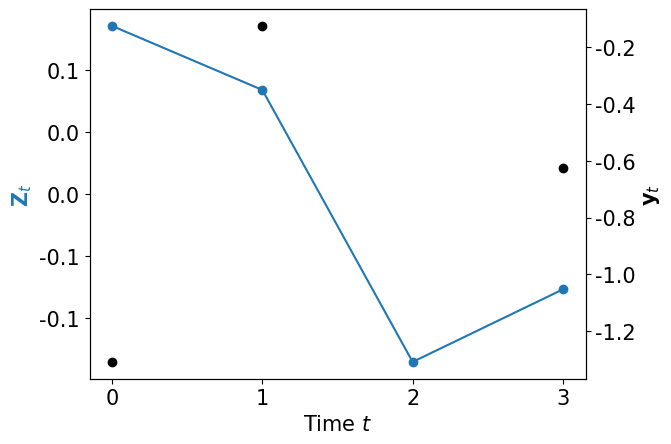

In [7]:
mu = -.5
phi = .95
sigma = 0.25
nsteps = 4
yB, ZA = SV.generate_data(nsteps, mu, sigma, phi)
yB[2] = None # Missing data y2
plot_data_dynamics(ZA, yB)

Let's then define $\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right)$ where we sequentially assimilate ${\bf y}_\Xi$ ...

In [8]:
pi = DECDIST.HiddenMarkovChainDistribution(
    pi_markov=DECDIST.MarkovChainDistribution([], pi_hyper), 
    ll_list=[]
)
for n, yt in enumerate(yB):
    if yt is None:
        ll = None
    else:
        ll = SV.LogLikelihood(yt, is_mu_h, is_sigma_h, is_phi_h)
    if n == 0: pin = pi_ic
    else: pin = pi_trans
    pi.append(pin, ll)

... check how non-Gaussian is $\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right)$ using its Laplace approximation $\widetilde{\pi}$ ...

In [9]:
lap = TM.laplace_approximation(pi)

2023-03-26 00:36:16 WARNING: TransportMaps: laplace_approximation(): Sampling from the prior is not implemented. Initial conditions set to zero.


... and computing the diagnostic $\mathbb{V}{\rm ar}_{\widetilde{\pi}}\left( \log \frac{\widetilde{\pi}}{\pi} \right)$

In [10]:
var = DIAG.variance_approx_kl(lap, pi, qtype=0, qparams=10000)
print("Variance diagnostic: %e" % var)

Variance diagnostic: 1.370653e+00


... We can also visualize the conditionals of $\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right)$ ...

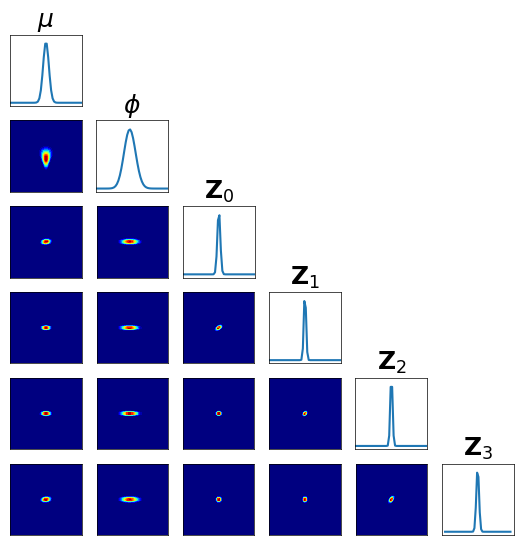

In [11]:
fig = plt.figure(figsize=(6.5,6.5))
fig = DIAG.plotAlignedConditionals( pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False,
    vartitles=[r"$\mu$",r"$\phi$",r"${\bf Z}_0$",r"${\bf Z}_1$",r"${\bf Z}_2$",r"${\bf Z}_3$"])

The direct approximation of $\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right)$ is impractical:

* It may be **high-dimensional** depending on the number of time steps
* We may want to be able to **update** the approximation as we assimilate data

## Low-dimensional couplings

We start with finding the map 

$$
\mathfrak{M}_0({\boldsymbol \theta}, {\bf z}_0, {\bf z}_1) = \left[
\begin{array}{l}
\mathfrak{M}^\Theta_0({\boldsymbol \theta}) \\
\mathfrak{M}^0_0({\boldsymbol \theta}, {\bf z}_0, {\bf z}_1) \\
\mathfrak{M}^1_0({\boldsymbol \theta}, {\bf z}_1)
\end{array}
\right] = Q \circ R_0 \circ Q
$$

that pushes forward $\mathcal{N}(0,{\bf I})$ to the **first Markov component** of $\pi\left( \left. \Theta, {\bf Z}_\Lambda \right\vert {\bf y}_\Xi \right)$:  

$$
\pi^{0}(\Theta, {\bf Z}_{0}, {\bf Z}_{1}) :=
\mathcal{L}({\bf y}_0 \vert \Theta, {\bf Z}_0) \mathcal{L}({\bf y}_1 \vert \Theta, {\bf Z}_1)
\pi({\bf Z}_{1} \vert \Theta, {\bf Z}_{0})
\pi({\bf Z}_{0} \vert \Theta) \pi(\Theta)
$$  

![](Figures/working/dataAssimilationHyper-s1-before.svg)

Define the map $R_0$, the permutation map $Q$ and the Markov component $\pi^0$ ...

In [12]:
order = 3
Q = MAPS.PermutationTransportMap([0,1,3,2])
R0 = MAPS.assemble_IsotropicIntegratedSquaredTriangularTransportMap(
    dim=4, order=order)
pi0 = pi.get_MarkovComponent(-1)

Let us then setup and solve the problem

$$
R_0 = \arg\min_{R \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( \left.R_\sharp \rho \, \right\vert \, Q^\sharp \pi^0 \right)
$$

In [13]:
rho = DIST.StandardNormalDistribution(dim=4)
pull_Q_pi0 = DIST.PullBackTransportMapDistribution(Q, pi0)
push_R0_rho = DIST.PushForwardTransportMapDistribution(R0, rho)
pull_R0_Q_pi0 = DIST.PullBackParametricTransportMapDistribution(R0, pull_Q_pi0)
qtype = 3       # Gauss quadrature
qparams = [6]*4 # Quadrature order
tol = 1e-4      # Optimization tolerance
ders = 2        # Use gradient and Hessian
log = KL.minimize_kl_divergence(
    rho, pull_R0_Q_pi0, qtype=qtype, qparams=qparams, 
    tol=tol, ders=ders)

... check accuracy looking at conditionals of $R_0^\sharp Q^\sharp \pi^0 \approx \rho$ ...

In [14]:
fig = plt.figure(figsize=(5.5,5.5))
varstr = [r"$\mu$",r"$\phi$",r"${\bf Z}_0$",r"${\bf Z}_1$"]

<Figure size 550x550 with 0 Axes>

In [15]:
pull_R0_Q_pi0 = DIST.PullBackTransportMapDistribution(R0, pull_Q_pi0)
fig = DIAG.plotAlignedConditionals(pull_R0_Q_pi0, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

![](Figures/working/dataAssimilationHyper-s1-before.svg)

Let now $T_0$ be

$$
T_0({\boldsymbol\theta}, {\bf z}_\Lambda) = 
\left[\begin{array}{c}
\mathfrak{M}_0({\boldsymbol \theta}, {\bf z}_0, {\bf z}_1) \\
{\bf z}_2 \\
{\bf z}_3
\end{array}\right]
$$

then for ${\bf X} \sim T_0^\sharp \pi$ we have $\left.{\bf X}_0 {\perp\!\!\!\perp} {\bf X}_{i} \right\vert {\bf X}_{\{\theta,\Lambda\} \setminus \{0,i\}} \;$, for $i\neq 0$.

![](Figures/working/dataAssimilationHyper-s1-after.svg)

Let us check the conditional independence of $T_0^\sharp \pi$ ...

In [16]:
fig = plt.figure(figsize=(6,6))
varstr_all = [r"$\mu$",r"$\phi$",r"${\bf Z}_0$",r"${\bf Z}_1$",r"${\bf Z}_2$",r"${\bf Z}_3$"]

<Figure size 600x600 with 0 Axes>

In [17]:
import TransportMaps.Maps.Decomposable as DECMAPS
M0 = MAPS.ListCompositeTransportMap(map_list=[Q, R0, Q])
Id = MAPS.IdentityTransportMap(M0.dim)
T0 = DECMAPS.SequentialMarkovChainTransportMap([M0,Id,Id], hyper_dim=2)
pull_T0_pi = DIST.PullBackTransportMapDistribution(T0, pi)
fig = DIAG.plotAlignedConditionals(pull_T0_pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr_all)

Let us now find the map

$$
\mathfrak{M}_1({\boldsymbol \theta}, {\bf z}_1, {\bf z}_2) = \left[
\begin{array}{l}
\mathfrak{M}^\Theta_1({\boldsymbol \theta}) \\
\mathfrak{M}^0_1({\boldsymbol \theta}, {\bf z}_1, {\bf z}_2) \\
\mathfrak{M}^1_1({\boldsymbol \theta}, {\bf z}_2)
\end{array}
\right] = Q \circ R_1 \circ Q
$$

that pushes forward $\mathcal{N}(0,{\bf I})$ to the **second Markov component** of $T_0^\sharp \pi$:

$$
\pi^{1}\left(\Theta, {\bf Z}_{1}, {\bf Z}_{2}\right) :=
\eta(\Theta, {\bf Z}_{1}) \,
\pi\left({\bf Z}_{2} \left\vert \Theta^\prime, {\bf Z}_1^\prime \right.\right) \quad \text{(missing observation)}\\
\Theta^\prime := \mathfrak{M}_{0}^{\Theta}(\Theta) \;, \quad {\bf Z}_1^\prime := \mathfrak{M}_{0}^{1}(\Theta, {\bf Z}_{1})
$$

![](Figures/working/dataAssimilationHyper-s2-before.svg)

In [21]:
R1 = MAPS.assemble_IsotropicIntegratedSquaredTriangularTransportMap(
    dim=4, order=order)
M0Theta = MAPS.ComponentwiseMap(active_vars=R0.active_vars[:2], approx_list=R0.approx_list[:2])
M01 = MAPS.ComponentwiseMap(active_vars=R0.active_vars[2:3], approx_list=R0.approx_list[2:3])
pi1 = pi.get_MarkovComponent(0, state_map=M01, hyper_map=M0Theta)

Let us then setup and solve the problem

$$
R_1 = \arg\min_{R \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( \left.R_\sharp \rho \, \right\vert \, Q^\sharp \pi^1 \right)
$$

In [22]:
pull_Q_pi1 = DIST.PullBackTransportMapDistribution(Q, pi1)
pull_R1_Q_pi1 = DIST.PullBackParametricTransportMapDistribution(R1, pull_Q_pi1)
log = KL.minimize_kl_divergence(
    rho, pull_R1_Q_pi1, qtype=qtype, qparams=qparams, 
    tol=tol, ders=ders)

... check the accuracy looking at the conditionals of $R_1^\sharp Q^\sharp \pi^1 \approx \rho$ ...

In [23]:
fig = plt.figure(figsize=(5.5,5.5))
varstr = [r"$\mu$",r"$\phi$",r"${\bf Z}_1$",r"${\bf Z}_2$"]

<Figure size 550x550 with 0 Axes>

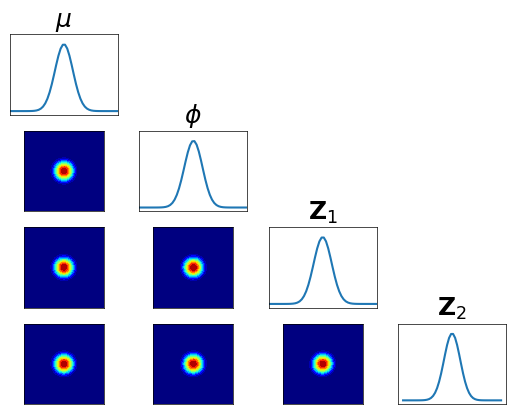

In [24]:
pull_R1_Q_pi1 = DIST.PullBackTransportMapDistribution(R1, pull_Q_pi1)
fig = DIAG.plotAlignedConditionals(pull_R1_Q_pi1, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

![](Figures/working/dataAssimilationHyper-s2-before.svg)

Let now $T_1$ be

$$
T_1({\boldsymbol\theta}, {\bf z}_\Lambda) = 
\left[\begin{array}{c}
\mathfrak{M}^\Theta_1({\boldsymbol \theta}) \\
{\bf z}_0 \\
\mathfrak{M}^0_1({\boldsymbol \theta}, {\bf z}_1, {\bf z}_2) \\
\mathfrak{M}^1_1({\boldsymbol \theta}, {\bf z}_2) \\
{\bf z}_{3}
\end{array}\right]
$$

then for ${\bf X} \sim T_1^\sharp T_0^\sharp \pi$ we have $\left.{\bf X}_{\{0,1\}} {\perp\!\!\!\perp} {\bf X}_{i} \right\vert {\bf X}_{\{\theta,\Lambda\} \setminus \{0,1,i\}} \;$, for $i \notin \{0,1\}$.

![](Figures/working/dataAssimilationHyper-s2-after.svg)

Let us check the conditional independence of $T_1^\sharp T_0^\sharp \pi$ ...

In [25]:
fig = plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

In [26]:
M1 = MAPS.ListCompositeTransportMap(map_list=[Q, R1, Q])
T1T0 = DECMAPS.SequentialMarkovChainTransportMap([M0,M1,Id], hyper_dim=2)
pull_T1T0_pi = DIST.PullBackTransportMapDistribution(T1T0, pi)
fig = DIAG.plotAlignedConditionals(pull_T1T0_pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr_all)

Let us finally find the map

$$
\mathfrak{M}_2({\boldsymbol \theta}, {\bf z}_2, {\bf z}_3) = \left[
\begin{array}{l}
\mathfrak{M}^\Theta_2({\boldsymbol \theta}) \\
\mathfrak{M}^0_2({\boldsymbol \theta}, {\bf z}_2, {\bf z}_3) \\
\mathfrak{M}^1_2({\boldsymbol \theta}, {\bf z}_3)
\end{array}
\right] = Q \circ R_2 \circ Q
$$

that pushes forward $\mathcal{N}(0,{\bf I})$ to the **third Markov component** of $T_1^\sharp T_0^\sharp \pi$:

$$
\pi^{2}\left(\Theta, {\bf Z}_{2}, {\bf Z}_{3}\right) :=
\eta(\Theta, {\bf Z}_{2}) \,
\mathcal{L}\left({\bf y}_3 \left\vert \Theta^{\prime\prime}, {\bf Z}_3 \right.\right)
\pi\left({\bf Z}_{3} \left\vert \Theta^{\prime\prime}, {\bf Z}_2^{\prime\prime} \right.\right) \\
\Theta^{\prime\prime} := \mathfrak{M}_{0}^{\Theta} \circ \mathfrak{M}_{1}^{\Theta}(\Theta) \;, 
\quad 
{\bf Z}_1^{\prime\prime} := \mathfrak{M}_{1}^{1}(\Theta, {\bf Z}_{2})
$$

![](Figures/working/dataAssimilationHyper-s3-before.svg)

In [29]:
R2 = MAPS.assemble_IsotropicIntegratedSquaredTriangularTransportMap(
    dim=4, order=order)
M1Theta = MAPS.ComponentwiseMap(active_vars=R1.active_vars[:2], approx_list=R1.approx_list[:2])
M0M1Theta = MAPS.CompositeMap(M0Theta, M1Theta)
M11 = MAPS.ComponentwiseMap(active_vars=R1.active_vars[2:3], approx_list=R1.approx_list[2:3])
pi2 = pi.get_MarkovComponent(1, state_map=M11, hyper_map=M0M1Theta)

Let us then setup and solve the problem

$$
R_2 = \arg\min_{R \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( \left.R_\sharp \rho \, \right\vert \, Q^\sharp \pi^2 \right)
$$

In [30]:
pull_Q_pi2 = DIST.PullBackTransportMapDistribution(Q, pi2)
pull_R2_Q_pi2 = DIST.PullBackParametricTransportMapDistribution(R2, pull_Q_pi2)
log = KL.minimize_kl_divergence(
    rho, pull_R2_Q_pi2, qtype=qtype, qparams=qparams, 
    tol=tol, ders=ders)

... check the accuracy looking at the conditionals of $R_2^\sharp Q^\sharp \pi^2 \approx \rho$ ...

In [31]:
plt.figure(figsize=(5.5,5.5))
varstr = [r"$\mu$",r"$\phi$",r"${\bf Z}_2$",r"${\bf Z}_3$"]

<Figure size 550x550 with 0 Axes>

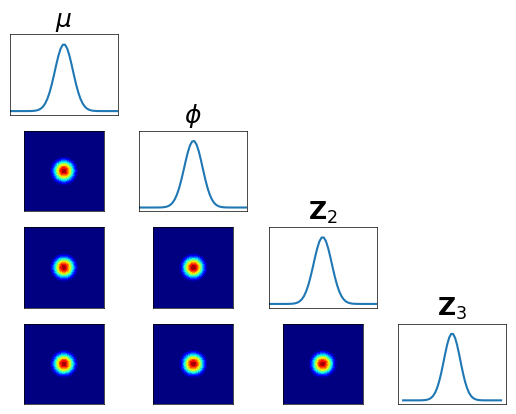

In [32]:
pull_R2_Q_pi2 = DIST.PullBackTransportMapDistribution(R2, pull_Q_pi2)
fig = DIAG.plotAlignedConditionals(pull_R2_Q_pi2, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr)

![](Figures/working/dataAssimilationHyper-s3-before.svg)

Let now $T_2$ be

$$
T_2({\boldsymbol\theta}, {\bf z}_\Lambda) = 
\left[\begin{array}{c}
\mathfrak{M}^\Theta_1({\boldsymbol \theta}) \\
{\bf z}_{0:1} \\
\mathfrak{M}^0_2({\boldsymbol \theta}, {\bf z}_2, {\bf z}_3) \\
\mathfrak{M}^1_2({\boldsymbol \theta}, {\bf z}_3) 
\end{array}\right]
$$

then $\mathfrak{T}^\sharp \pi := T_2^\sharp T_1^\sharp T_0^\sharp \pi \approx \mathcal{N}(0,{\bf I})$.

![](Figures/working/dataAssimilationHyper-s3-after.svg)

Let us check the conditional independence of $\mathfrak{T}^\sharp \pi$ ...

In [33]:
fig = plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

In [35]:
M2 = MAPS.ListCompositeTransportMap(map_list=[Q, R2, Q])
T = DECMAPS.SequentialMarkovChainTransportMap([M0,M1,M2], hyper_dim=2)
pull_T_pi = DIST.PullBackTransportMapDistribution(T, pi)
fig = DIAG.plotAlignedConditionals(pull_T_pi, range_vec=[-6,6], 
    numPointsXax=50, fig=fig, show_flag=False, vartitles=varstr_all)

... and we can compare its the variance $\mathbb{V}{\rm ar}\left[ \frac{\rho}{\mathfrak{T}^\sharp \pi} \right]$ with the Laplace approximation ...

In [36]:
rho = DIST.StandardNormalDistribution(pull_T_pi.dim)
var_lap = DIAG.variance_approx_kl(lap, pi, qtype=0, qparams=10000)
var_seq = DIAG.variance_approx_kl(rho, pull_T_pi, qtype=0, qparams=10000)
print("Variance diagnostic - Laplace:    %e" % var_lap)
print("Variance diagnostic - Sequential: %e" % var_seq)

Variance diagnostic - Laplace:    1.162491e+00
Variance diagnostic - Sequential: 8.439695e-02


## Smoothing distribution

We can easily generate a **biased** sample of $\pi$ via $\mathfrak{T}_\sharp \rho \approx \pi$ ...

In [37]:
push_T_rho = DIST.PushForwardTransportMapDistribution(T, rho)
bias_samp_pi = push_T_rho.rvs(10000)

... or one can generate an **unbiased** Monte-Carlo Markov chain for $\pi$ as follows:

1. generate a Markov chain (MC) with 
    * invariant distribution $T^\sharp \pi$ 
    * using proposal distribution $\rho$
2. push forward the MC through T obtaining a MC with 
    * invariant distribution $\pi$.

In [38]:
import TransportMaps.Samplers as SAMP
sampler = SAMP.MetropolisHastingsIndependentProposalsSampler(
    pull_T_pi, rho)
burnin = 1000
(x, _) = sampler.rvs(10000)
x = x[burnin:,:]
unbias_samp_pi = T.evaluate(x) # Markov chain from \pi

Let us visualize the marginals of the hyper-parameters $\pi\left(\mu\left\vert {\bf y}_\Xi\right.\right)$ and $\pi\left(\phi\left\vert {\bf y}_\Xi\right.\right)$ ...

In [39]:
def plot_marginal_hyper(bias_samp, unbias_samp):
    import numpy as np
    import scipy.stats as stats
    fig = plt.figure(figsize=(11,4.5))
    # \mu
    ax1 = fig.add_subplot(121)
    mu_bias_kde = stats.gaussian_kde(bias_samp[:,0])
    mu_unbias_kde = stats.gaussian_kde(unbias_samp[:,0])
    mu_min = min(np.min(bias_samp[:,0]), np.min(unbias_samp[:,0]))
    mu_max = max(np.max(bias_samp[:,0]), np.max(unbias_samp[:,0]))
    mu_x = np.linspace(mu_min, mu_max, 100)
    ax1.plot(mu_x, mu_bias_kde(mu_x), label='Biased')
    ax1.plot(mu_x, mu_unbias_kde(mu_x), label='Unbiased')
    ax1.legend(loc='lower center')
    ax1.set_xlabel(r"$\mu$")
    ax1.set_ylabel(r"$\pi_{\rm pos}(\mu)$")
    # \phi
    ax2 = fig.add_subplot(122)
    phi_bias_samp = phi_h.evaluate(bias_samp[:,1])
    phi_unbias_samp = phi_h.evaluate(unbias_samp[:,1])
    phi_bias_kde = stats.gaussian_kde(phi_bias_samp)
    phi_unbias_kde = stats.gaussian_kde(phi_unbias_samp)
    phi_min = min(np.min(phi_bias_samp), np.min(phi_unbias_samp))
    phi_max = max(np.max(phi_bias_samp), np.max(phi_unbias_samp))
    phi_x = np.linspace(phi_min, phi_max, 100)
    ax2.plot(phi_x, phi_bias_kde(phi_x), label='Biased')
    ax2.plot(phi_x, phi_unbias_kde(phi_x), label='Unbiased')
    ax2.legend(loc='upper left')
    ax2.set_xlabel(r"$\phi$")
    ax2.set_ylabel(r"$\pi_{\rm pos}(\phi)$")
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

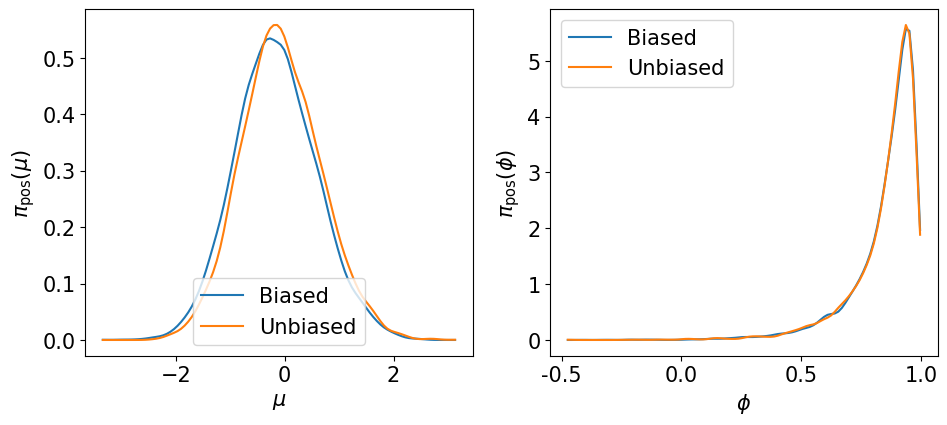

In [40]:
plot_marginal_hyper(bias_samp_pi, unbias_samp_pi)

... the smoothing marginals of the states $\pi\left(\left.{\bf Z}_k\right\vert {\bf y}_\Xi\right)$ ...

In [41]:
def plot_state_mean_percentiles(Zt, bias_samp, unbias_samp=None, fig=None, marker='o-'):
    import numpy as np
    if fig is None:
        fig = plt.figure(figsize=(11,4.5))
    # Biased
    ax1 = fig.add_subplot(121)
    l1, = ax1.plot(Zt, marker, label=r"${\bf Z}_t$")
    ax1.set_xlabel(r"Time $t$")
    ax1.set_ylabel(r"${\bf Z}_t$")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    bias_mean = np.mean(bias_samp, axis=0)
    bias_p5 = np.percentile(bias_samp, q=5., axis=0)
    bias_p20 = np.percentile(bias_samp, q=20., axis=0)
    bias_p80 = np.percentile(bias_samp, q=80., axis=0)
    bias_p95 = np.percentile(bias_samp, q=95., axis=0)
    ax1.plot(bias_mean, marker + 'k', label=r"$\mathbb{E}[{\bf Z}_t \vert {\bf y}_t]$")
    ax1.fill_between(range(nsteps),y1=bias_p5, y2=bias_p95, color='r', alpha=.10)
    ax1.fill_between(range(nsteps),y1=bias_p20, y2=bias_p80, color='r', alpha=.15)
    ax1.legend()
    ax1.set_title("Biased sample")
    if unbias_samp is not None:
        # Unbiased
        ax2 = fig.add_subplot(122)
        l1, = ax2.plot(Zt, marker, label=r"${\bf Z}_t$")
        ax2.set_xlabel(r"Time $t$")
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        unbias_mean = np.mean(unbias_samp, axis=0)
        unbias_p5 = np.percentile(unbias_samp, q=5., axis=0)
        unbias_p20 = np.percentile(unbias_samp, q=20., axis=0)
        unbias_p80 = np.percentile(unbias_samp, q=80., axis=0)
        unbias_p95 = np.percentile(unbias_samp, q=95., axis=0)
        ax2.plot(unbias_mean, marker+'k', label=r"$\mathbb{E}[{\bf Z}_t \vert {\bf y}_t]$")
        ax2.fill_between(range(nsteps),y1=unbias_p5, y2=unbias_p95, color='r', alpha=.10)
        ax2.fill_between(range(nsteps),y1=unbias_p20, y2=unbias_p80, color='r', alpha=.15)
        ax2.legend()
        ax2.set_title("Unbiased sample")

In [42]:
plot_state_mean_percentiles(ZA, bias_samp_pi[:,2:], unbias_samp_pi[:,2:])

## Filtering distribution

We have that

$$
\widetilde{\mathfrak{M}}_k({\bf x}_\theta, {\bf x}_{k+1}) = 
\left[\begin{array}{l}
\mathfrak{M}_0^\Theta \circ \cdots \circ \mathfrak{M}_{k}^\Theta ({\bf x}_\theta) \\
\mathfrak{M}_k^1\left({\bf x}_\theta, {\bf x}_{k+1}\right)
\end{array}\right]
$$

pushes forward $\mathcal{N}(0,{\bf I})$ to the filtering distribution $\pi\left(\left.\Theta,{\bf Z}_{k+1}\right\vert {\bf y}_{0:k+1} \right)$. 

Let us generate samples for the filtering of the states $\pi\left(\left.{\bf Z}_{k+1}\right\vert {\bf y}_{0:k+1} \right)$:

In [43]:
R_list = [R0, R1, R2]
M1k_list = [
    MAPS.ComponentwiseMap(
        active_vars=R.active_vars[2:3],
        approx_list=R.approx_list[2:3]
    )
    for R in R_list
]
filt_samp = np.zeros((10000,nsteps))
rho_0 = DIST.StandardNormalDistribution(4)
push = DIST.PushForwardTransportMapDistribution(M0, rho_0)
filt_samp[:,0:2] = push.rvs(10000)[:,2:4]
rho_filt = DIST.StandardNormalDistribution(3)
for n in range(2,nsteps):
    filt_samp[:,n:n+1] = M1k_list[n-1].evaluate(rho_filt.rvs(10000))

... and let us visualize $\pi\left(\left.{\bf Z}_{k+1}\right\vert {\bf y}_{0:k+1} \right)$ ...

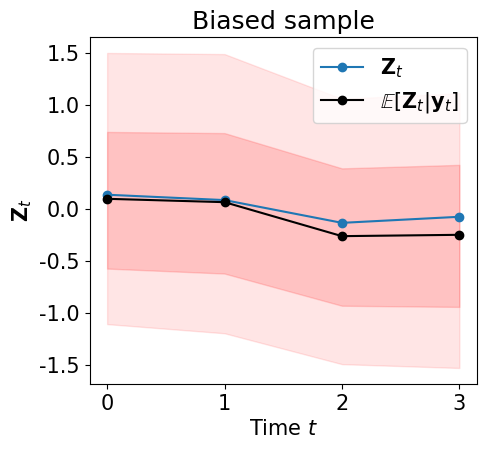

In [44]:
plot_state_mean_percentiles(ZA, filt_samp)

## On-line data assimilation

Let us generate more data ...

In [45]:
nsteps = 51
yB, ZA = SV.generate_data(nsteps, mu, sigma, phi)
plot_data_dynamics(ZA, yB, fig=plt.figure(figsize=(10,4.5)))

... and let us assimilate these data on-line ...

In [56]:
import TransportMaps.Algorithms.SequentialInference as ALG
INT = ALG.TransportMapsSmoother(pi_hyper)
for n, yt in enumerate(yB):
    if yt is None: ll = None # Missing data
    else: ll = SV.LogLikelihood(yt, is_mu_h, is_sigma_h, is_phi_h)
    if n == 0: pin = pi_ic # Prior initial conditions
    else: pin = pi_trans   # Prior transition dynamics
    # Transport map specification
    if n == 0: dim_tm = 3
    else: dim_tm = 4
    tm = MAPS.assemble_IsotropicIntegratedSquaredTriangularTransportMap(
        dim=dim_tm, order=3)
    # Solution parameters
    solve_params = {'qtype': 3, 'qparams': [6]*dim_tm, 
                    'tol': 1e-4}
    # Regression map specification
    hyper_tm = MAPS.assemble_IsotropicIntegratedSquaredTriangularTransportMap(
        dim=pi_hyper.dim, order=4)
    # Regression parameters
    rho_hyper = DIST.StandardNormalDistribution(pi_hyper.dim)
    reg_params = {'d': rho_hyper, 'qtype': 3, 'qparams': [7]*pi_hyper.dim, 
                  'tol': 1e-4}
    # Assimilation
    print("%3d" % n, end="")
    INT.assimilate(
        pin, ll, tm, solve_params, 
        hyper_tm=hyper_tm, regression_params=reg_params)

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

In the script above the class [SequenatialHiddenMarkovChainIntegrator](api-TransportMaps.html#TransportMaps.SequentialHiddenMarkovChainIntegrator) takes care of assimilating new components $\left( \mathcal{L}\left({\bf y}_{k+1} \left\vert \Theta, {\bf Z}_{k+1}\right.\right), \pi\left(\left.{\bf Z}_{k+1} \right\vert {\bf Z}_{k}, \Theta\right) \right)$ in the approximation of the smoothing distribution, whether new data ${\bf y}_t$ becomes available or not.  
The steps ``INT.assimilate`` takes care of approximating the map $R_k$ using the transport map ``tm`` and the solution parameters ``solve_params`` (see [TransportMap.minimize_kl_divergence](api-TransportMaps-Maps.html#TransportMaps.Maps.TransportMap.minimize_kl_divergence)). It also construct the map $\mathfrak{M}_k = Q \circ R_k \circ Q$ and embeds it into the identity map $T_k$.  
Additionally it performs the optional step of compressing the map $\mathfrak{M}_{0}^\Theta \circ \ldots \circ \mathfrak{M}_{k-1}^\Theta$ into the map $\mathfrak{H}_{k-1}$ by recursevly solving the regression problem (see [TransportMap.regression](api-TransportMaps-Maps.html#TransportMaps.Maps.TransportMap.regression))

$$
\mathfrak{H}_{k-1} = \arg\min_{H \in T} \Vert H - \mathfrak{H}_{k-2} \circ \mathfrak{M}_{k-1}^\Theta \Vert_{L_\mu^2} \;.
$$

This allows a faster evaluation of the $k$-th Markov component, which depends on $\mathfrak{H}_{k-1}$.

Let us check the accuracy using the diagnostic $\mathbb{V}{\rm ar}\left[ \frac{\rho}{\mathfrak{T}^\sharp \pi} \right]$ ...

In [57]:
T = INT.smoothing_map
pi = INT.pi
pull_T_pi = DIST.PullBackTransportMapDistribution(T, pi)
rho = DIST.StandardNormalDistribution(pi.dim)
lap = TM.laplace_approximation(pi)
var_lap = DIAG.variance_approx_kl(lap, pi, qtype=0, qparams=10000)
var_seq = DIAG.variance_approx_kl(rho, pull_T_pi, qtype=0, qparams=10000)
print("Variance diagnostic - Laplace:    %e" % var_lap)
print("Variance diagnostic - Sequential: %e" % var_seq)

2023-03-26 00:55:01 WARNING: TransportMaps: laplace_approximation(): Sampling from the prior is not implemented. Initial conditions set to zero.
Variance diagnostic - Laplace:    3.596890e+01
Variance diagnostic - Sequential: 1.654149e+00


Let us generate samples from $\mathfrak{T}_\sharp \rho$ (biased samples of $\pi$) ...

In [58]:
push_T_rho = DIST.PushForwardTransportMapDistribution(T, rho)
bias_samp_pi = push_T_rho.rvs(10000)

... and unbiased samples from $\pi$ ...

In [59]:
import TransportMaps.Samplers as SAMP
sampler = SAMP.MetropolisHastingsIndependentProposalsSampler(
    pull_T_pi, rho)
(x, _) = sampler.rvs(10000)
x = x[5000:,:]
unbias_samp_pi = T.evaluate(x) # Markov chain from \pi

Let us visualize the marginals of the hyper-parameters $\pi\left(\mu\left\vert {\bf y}_\Xi\right.\right)$ and $\pi\left(\phi\left\vert {\bf y}_\Xi\right.\right)$ ...

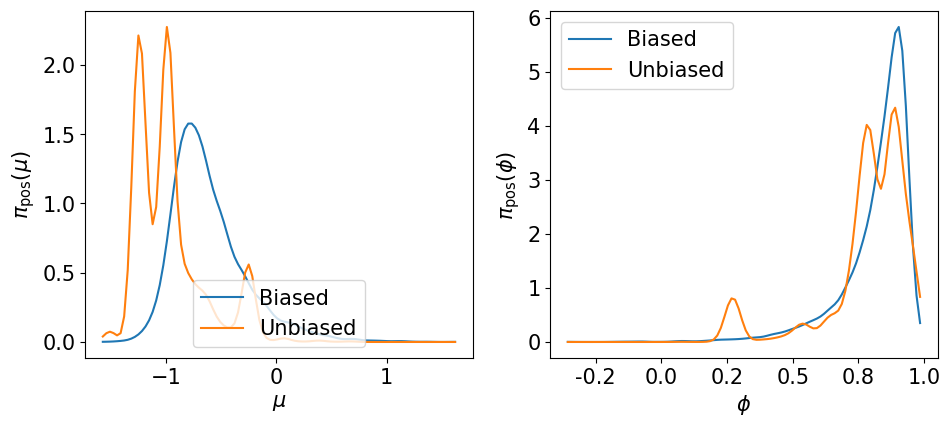

In [60]:
plot_marginal_hyper(bias_samp_pi, unbias_samp_pi)

... and the smoothing marginals of the states $\pi\left(\left.{\bf Z}_k\right\vert {\bf y}_\Xi\right)$ ...

In [61]:
plot_state_mean_percentiles(ZA, bias_samp_pi[:,2:], unbias_samp_pi[:,2:], 
                            fig=plt.figure(figsize=(13,4.5)), marker='-')

We can sample the filtering distributions $\pi\left(\mu \middle\vert {\bf y}_{0:k}\right)$, $\pi\left(\phi\middle\vert {\bf y}_{0:k}\right)$, $\pi\left({\bf Z}_k\middle\vert {\bf y}_{0:k}\right)$ ...

In [62]:
filt_tm_list = INT.filtering_map_list
rho = DIST.StandardNormalDistribution(3)
samp_list = []
for tm in filt_tm_list:
    push_tm_rho = DIST.PushForwardTransportMapDistribution(tm, rho)
    samp_list.append( push_tm_rho.rvs(10000) )

... and visualize them ...

In [63]:
def plot_filtering(Zt, mu, phi, samp_list, fig=None, marker='o-'):
    import numpy as np
    mu_samp = np.vstack([ s[:,0] for s in samp_list ]).T
    phi_samp = np.vstack([ s[:,1] for s in samp_list ]).T
    phi_samp = phi_h.evaluate(phi_samp)
    state_samp = np.vstack([ s[:,2] for s in samp_list ]).T
    if fig is None:
        fig = plt.figure(figsize=(15,4.5))
    # mu
    ax1 = fig.add_subplot(131)
    ax1.plot(range(nsteps), np.ones(nsteps)*mu, marker, label=r"$\mu$")
    ax1.set_xlabel(r"Time $t$")
    #ax1.set_ylabel(r"$\mu$")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    mean = np.mean(mu_samp, axis=0)
    p5 = np.percentile(mu_samp, q=5., axis=0)
    p20 = np.percentile(mu_samp, q=20., axis=0)
    p40 = np.percentile(mu_samp, q=40., axis=0)
    p60 = np.percentile(mu_samp, q=60., axis=0)
    p80 = np.percentile(mu_samp, q=80., axis=0)
    p95 = np.percentile(mu_samp, q=95., axis=0)
    ax1.plot(mean, marker + 'k', label=r"$\mathbb{E}[\mu \vert {\bf y}_{0:k}]$")
    ax1.fill_between(range(nsteps),y1=p5, y2=p95, color='r', alpha=.10)
    ax1.fill_between(range(nsteps),y1=p20, y2=p80, color='r', alpha=.13)
    ax1.fill_between(range(nsteps),y1=p40, y2=p60, color='r', alpha=.16)
    ax1.legend()
    # phi
    ax2 = fig.add_subplot(132)
    ax2.plot(range(nsteps), np.ones(nsteps)*phi, marker, label=r"$\phi$")
    ax2.set_xlabel(r"Time $t$")
    #ax2.set_ylabel(r"$\phi$")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    mean = np.mean(phi_samp, axis=0)
    p5 = np.percentile(phi_samp, q=5., axis=0)
    p20 = np.percentile(phi_samp, q=20., axis=0)
    p40 = np.percentile(phi_samp, q=40., axis=0)
    p60 = np.percentile(phi_samp, q=60., axis=0)
    p80 = np.percentile(phi_samp, q=80., axis=0)
    p95 = np.percentile(phi_samp, q=95., axis=0)
    ax2.plot(mean, marker + 'k', label=r"$\mathbb{E}[\phi \vert {\bf y}_{0:k}]$")
    ax2.fill_between(range(nsteps),y1=p5, y2=p95, color='r', alpha=.10)
    ax2.fill_between(range(nsteps),y1=p20, y2=p80, color='r', alpha=.13)
    ax2.fill_between(range(nsteps),y1=p40, y2=p60, color='r', alpha=.16)
    ax2.legend()
    # states
    ax3 = fig.add_subplot(133)
    l1, = ax3.plot(Zt, marker, label=r"${\bf Z}_t$")
    ax3.set_xlabel(r"Time $t$")
    #ax3.set_ylabel(r"${\bf Z}_t$")
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    mean = np.mean(state_samp, axis=0)
    p5 = np.percentile(state_samp, q=5., axis=0)
    p20 = np.percentile(state_samp, q=20., axis=0)
    p40 = np.percentile(state_samp, q=40., axis=0)
    p60 = np.percentile(state_samp, q=60., axis=0)
    p80 = np.percentile(state_samp, q=80., axis=0)
    p95 = np.percentile(state_samp, q=95., axis=0)
    ax3.plot(mean, marker + 'k', label=r"$\mathbb{E}[{\bf Z}_t \vert {\bf y}_t]$")
    ax3.fill_between(range(nsteps),y1=p5, y2=p95, color='r', alpha=.10)
    ax3.fill_between(range(nsteps),y1=p20, y2=p80, color='r', alpha=.13)
    ax3.fill_between(range(nsteps),y1=p40, y2=p60, color='r', alpha=.16)
    ax3.legend()

In [64]:
plot_filtering(ZA, mu, phi, samp_list, marker='-')